# Interpolation

### Prerequisites

**Imports**

In [97]:
import os
import sys
import warnings
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
import matplotlib.pyplot as plt

**Fix directories, define path variables**

In [98]:
# make sure notebook is ran from src
cwd = os.getcwd()
if not cwd.split('/')[-1] == 'src':
    try:
        os.chdir('src')
    except FileNotFoundError:
        print('Error: please run from src dir or project root')
        sys.exit(1)

# define paths
data_path = '../data/'
csv_path = data_path + 'csv/'
shp_path = data_path + 'shapefiles/'
plot_path = '../plots/'
if not os.path.exists(plot_path):
    os.mkdir(plot_path)

---

### Read data

In [99]:
# streets data
STREETS = gpd.read_file(shp_path + 'streets/M_streets.shp')

# traffic data
TRAFFIC = gpd.read_file(shp_path + 'traffic/M_traffic.shp')

# grid
GRID = gpd.read_file(shp_path + 'grid2/M_grid2.shp')

TRAFFIC.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 738 entries, 0 to 737
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   RequestID  738 non-null    int64   
 1   Boro       738 non-null    object  
 2   SegmentID  738 non-null    int64   
 3   street     738 non-null    object  
 4   fromSt     738 non-null    object  
 5   toSt       738 non-null    object  
 6   Direction  738 non-null    object  
 7   Avg_Vol    738 non-null    float64 
 8   geometry   738 non-null    geometry
dtypes: float64(1), geometry(1), int64(2), object(5)
memory usage: 52.0+ KB


---

### Interpolate traffic data

In [100]:
x, y = TRAFFIC.geometry.x.values, TRAFFIC.geometry.y.values
phi = TRAFFIC.Avg_Vol.values

assert x.shape[0] == y.shape[0] == phi.shape[0]

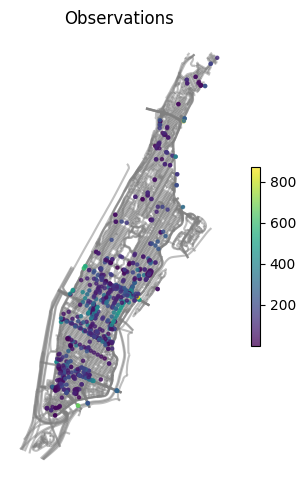

In [101]:
fig, ax = plt.subplots(figsize=(5, 5))
cax = ax.scatter(x, y, c=phi, cmap='viridis', s=5, alpha=0.75, zorder=2)
STREETS.plot(ax=ax, color='gray', alpha=0.5, zorder=1)
ax.set_title('Observations')
ax.set_axis_off()
fig.colorbar(cax, ax=ax, shrink=0.4)
fig.tight_layout()

In [102]:
OK = OrdinaryKriging(x, y, phi, variogram_model='exponential', verbose=False, enable_plotting=False)
minx, miny, maxx, maxy = GRID.total_bounds
X = np.arange(minx, maxx, 0.005)
Y = np.arange(miny, maxy-0.005, 0.005)
zstar, ss = OK.execute('grid', X, Y)

In [103]:
type(zstar)

numpy.ma.core.MaskedArray

In [104]:
# read in grid2 shapefile
GRID2 = gpd.read_file(shp_path + 'grid2/M_grid2.shp')

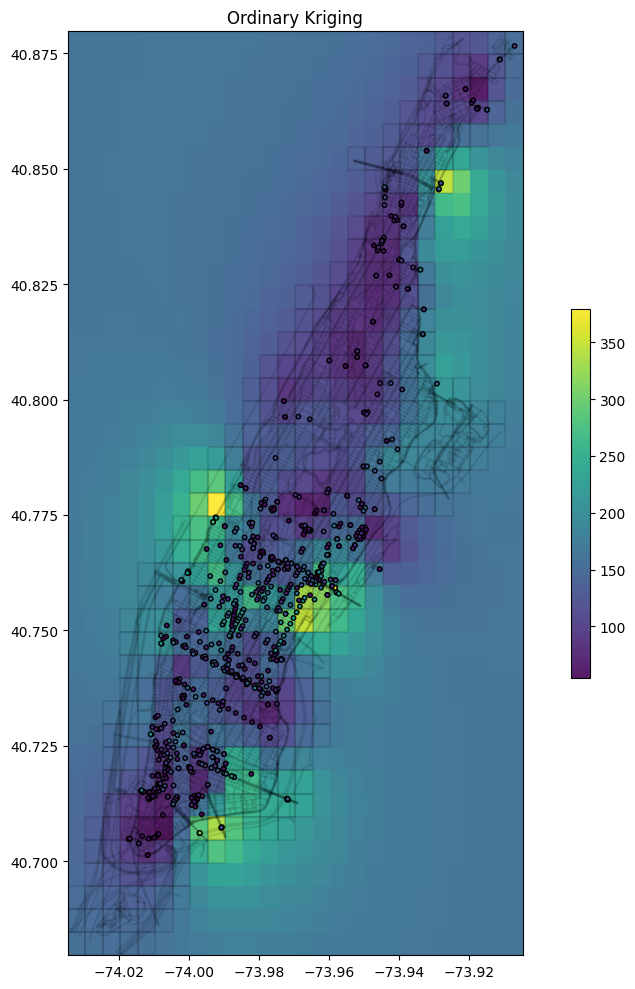

In [105]:
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.imshow(
    zstar,
    extent = (minx, maxx, miny, maxy),
    cmap = 'viridis',
    origin = 'lower',
    alpha = 0.9,
    zorder = 1
)
STREETS.plot(
    ax = ax,
    color = 'k',
    alpha = 0.1,
    zorder = 2
)
# loop over grid2 polygons and add them to the plot as black windows
for i, row in GRID2.iterrows():
    poly = row.geometry
    x_, y_ = poly.exterior.xy
    ax.plot(x_, y_, color='k', alpha=0.1, zorder=3)
ax.scatter(x, y, c=phi, cmap='viridis', edgecolors='k', s=10, zorder=3)
ax.set_title('Ordinary Kriging')
fig.colorbar(cax, ax=ax, shrink=0.4)
fig.tight_layout()
fig.savefig(plot_path + 'ordinary_kriging.png', dpi=300)

<AxesSubplot: >

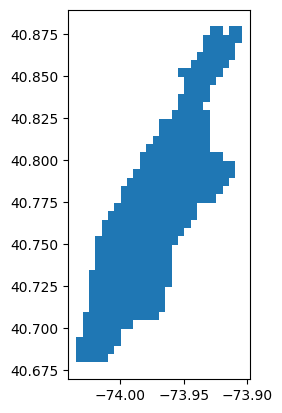

In [106]:
GRID2.plot()

In [107]:
GRID2.shape

(393, 6)

In [108]:
zstar.shape

(40, 26)

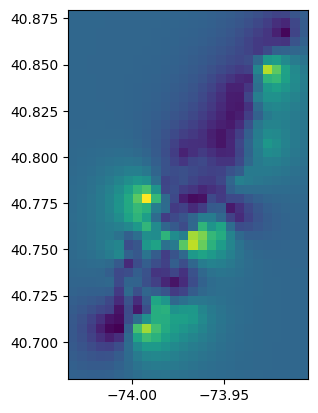

In [109]:
plt.imshow(zstar, extent=(minx, maxx, miny, maxy), origin='lower', cmap='viridis')